# Attenuation Factor

In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import numpy.testing as npt
from operator import itemgetter, attrgetter
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

2017-12-19 00:53:41


In [2]:
from pynext.system_of_units import *

In [3]:
import scipy as sp

In [4]:
from scipy.integrate import quad

## Infinite slab approximation

Assuming that the material is an infinte slab with an specific activity A0 (Bq/[M]) and a thickness z ([L])
then the flux that escapes the material (not self-shielded) trhough one of the surfaces is given by:

  $\Phi ([S]) = \rho * A0 * I / (2\pi)$,
  
   where:
   
   $I = \int_{-pi/2}^{pi/2} \frac{\cos(\theta)}{\mu L} (1 - e^{-\frac{\mu L}{\cos(\theta)}}) $

   

In [5]:
class SelfAtt:
    def __init__(self, mu, L):
        self.mu = mu
        self.L  = L

    def f(self, theta):
        a1 = np.cos(theta) / (self.mu * self.L)
        a2 = np.exp(-self.mu * self.L / np.cos(theta))
        return a1 * (1 - a2)

In [6]:
class Attf:
    def __init__(self, mu, L):
        self.mu = mu
        self.L  = L
        
    def f(self, theta):
        return (np.cos(theta) / (self.mu * self.L)) * (1 -(np.exp(-self.mu * self.L / np.cos(theta))))

for mu/L = 0.0001 transmitted flux = 0.4998152706407704
for mu/L = 0.1 transmitted flux = 0.43760831010039614
for mu/L = 1.0 transmitted flux = 0.23121369415728554
for mu/L = 10.0 transmitted flux = 0.03183046846993058
for mu/L = 100.0 transmitted flux = 0.003183098845922413


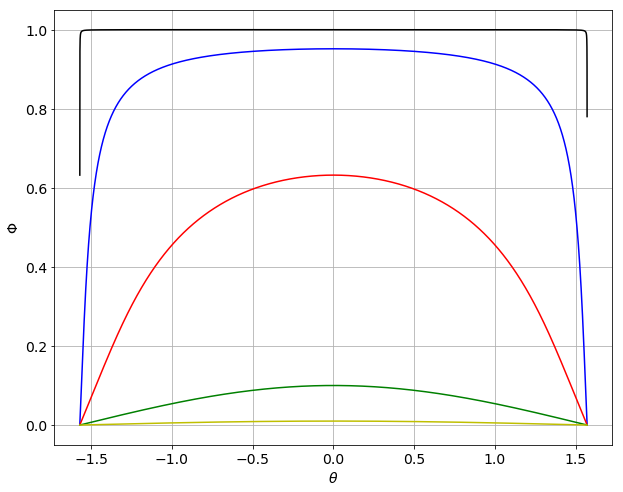

In [13]:
a = -np.pi/2 + 0.0001
b = np.pi/2 -  0.0001
I = []
MU = (0.0001, 0.1, 1., 10., 100.)
THETA = np.arange(a,b,0.0001)
for mu, c in zip(MU, ('k','b','r','g','y')):
    att = SelfAtt(mu=mu, L=1)
    T   = att.f(THETA)
    plt.plot(THETA, T,c)
    tf, _ = quad(att.f, a, b)
    I.append(tf)
    print('for mu/L = {} transmitted flux = {}'.format(mu, tf / (2 * np.pi)))
plt.grid(True)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\Phi$')
#plt.text(-0.5, 0.9, r'$\mu={0:5.3f} \, g/cm^3$'.format(rho_3020/ (g/cm3)))
plt.show()

In [15]:
MU = np.logspace(-4, 2, num=100)

In [18]:
T=[]
I = []
for i in range(len(MU)):
    att = SelfAtt(mu=MU[i], L=1)
    tf, _ = quad(att.f, a, b)
    I.append(tf / (2 * np.pi))
II = np.array(I)

In [19]:
II.shape

(100,)

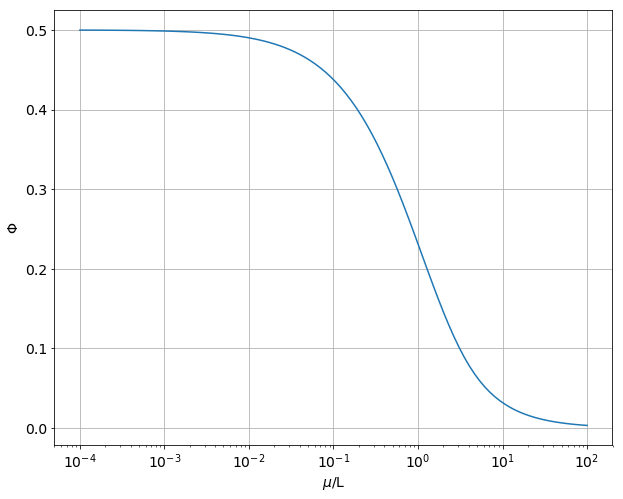

In [20]:
plt.semilogx(MU, I)
plt.grid(True)
plt.xlabel(r'$\mu$/L')
plt.ylabel(r'$\Phi$')

#### NB, transmitted flux when mu -->0 is 0.5 (half of the flux goes backward)

### Self attenuation of various materials

In [62]:
from pynext.Material import RadioactiveMaterial
from pynext.Shapes import Brick
from pynext.PhysicalVolume import PhysicalVolume

1. Define a slab (a brick with lateral dimensions much larger than thickness)
2. Filled the slab with 4 materials (steel-ti316, cu, pb, Kryptonite) forcing the same mass activity in the three
3. Compute activity as a function of thickness (takes into account self-shield)
4. Notice that Kryptonite is much denser (and has much higher stopping power) than Earth materials

In [63]:
brick = Brick(100 * cm, 100 * cm, 10 * cm)
brick


        Brick(width= 1.00e+00 m , heigth= 1.00e+00 m , lengthR= 1.00e-01 m)
        

        radius            = 0.00e+00 mm
        thickness         = 0.00e+00 mm
        inner_volume      = 1.00e-01 m3
        shell_volume      = 0.00e+00 m3
        inner_surface     = 2.40e+00 m2
        outer_surface     = 2.40e+00 m2
        thickness_surface = 0.00e+00 m2

        volume            = 1.00e-01 m3
        surface           = 2.40e+00 m2
        

In [70]:
A_BI214_316Ti   =    1    * mBq/kg
A_TL208_316Ti   =    0.15 * mBq/kg
ti316  = RadioactiveMaterial(name='316ti', rho=7.87 * g/cm3, mu_over_rho=0.039 * cm2/g,
                            a_bi214=A_BI214_316Ti, a_tl208=A_TL208_316Ti)

cu = RadioactiveMaterial(name='Cu',
                           rho = 8.96 * g/cm3,
                           mu_over_rho = 0.039 * cm2/g,
                           a_bi214=A_BI214_316Ti, a_tl208=A_TL208_316Ti)


pb =   RadioactiveMaterial(name='Pb',
                           rho = 11.33 * g/cm3,
                           mu_over_rho = 0.044 * cm2/g,
                           a_bi214=A_BI214_316Ti, a_tl208=A_TL208_316Ti)

kryp =   RadioactiveMaterial(name='Kryptonite',
                           rho = 20 * g/cm3,
                           mu_over_rho = 0.1 * cm2/g,
                           a_bi214=A_BI214_316Ti, a_tl208=A_TL208_316Ti)

In [147]:
M = {}
Z = np.arange(0.1, 20,0.01)
for material in ('ti316', 'cu', 'pb', 'kryp'):
    slab = PhysicalVolume('slab',eval(material), brick)
    A = []
    
    for z in Z:
        A.append(slab.activity_bi214_self_shield(z * cm) / slab.activity_bi214)
    M[material]=A

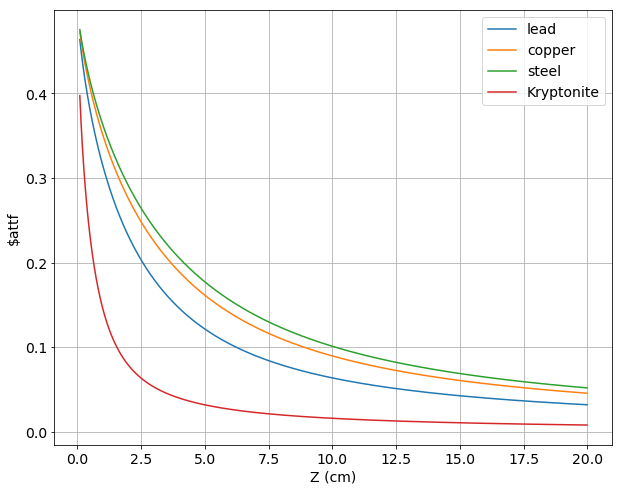

In [148]:
plt.plot(Z, M['pb'], label='lead')
plt.plot(Z, M['cu'], label='copper')
plt.plot(Z, M['ti316'], label='steel')
plt.plot(Z, M['kryp'], label='Kryptonite')
plt.grid(True)
plt.xlabel(r'Z (cm)')
plt.ylabel(r'$attf')
plt.legend()
plt.show()

## MC calculation

In [149]:
mu_cu = cu.mu_over_rho * cu.rho
Latt = 1/mu_cu
Latt / cm

2.8617216117216113

In [78]:
r= np.random.exponential(scale=Latt, size=1000)

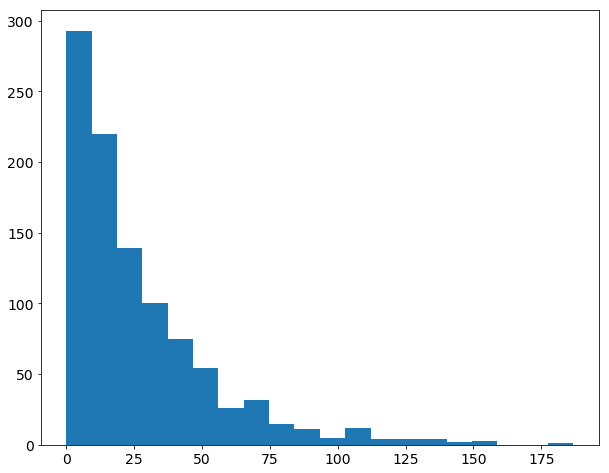

In [151]:
bins = plt.hist(r, bins=20)

In [152]:
def att_factor(z, mu, test_size=10000, ymin=0, ymax=1000):
    Latt = 1 / mu
    a = -np.pi/2 + 0.0001
    b = np.pi/2 -  0.0001
    x0 = np.random.uniform(low=0.0, high=z, size=test_size)
    t0 = np.random.uniform(low=a, high=b, size=test_size)
    r0 = x0 / np.cos(t0)
    r= np.random.exponential(scale=Latt, size=test_size)
    return np.count_nonzero(np.greater(r, r0)) / test_size

In [153]:
Z = np.arange(0.1, 20,0.01)
attf = [att_factor(z * cm, cu.mu_over_rho * cu.rho) /2 for z in Z]

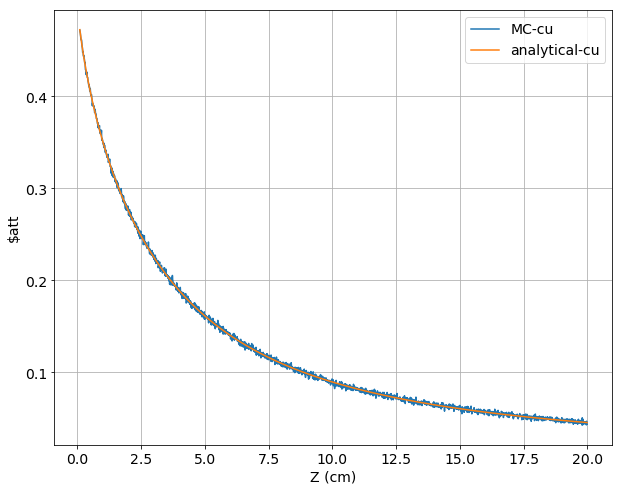

In [154]:
plt.plot(Z, attf, label='MC-cu')
plt.plot(Z, M['cu'], label='analytical-cu')
plt.grid(True)
plt.xlabel(r'Z (cm)')
plt.ylabel(r'$att')
plt.legend()
plt.show()